# EDA - MovieLens Data Exploration

In [4]:
# # MovieLens Data Exploration
# This notebook explores the ratings.csv file to understand the data distribution.

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# -------------------------------------
from surprise import Reader, Dataset, KNNBasic, SVD, SVDpp, NMF
from surprise.model_selection import cross_validate

In [5]:
# Set a nice style for the plots
sns.set_style("whitegrid")

# %%
# 1. Load the Data
# ----------------
# Make sure 'ratings.csv' is in the same folder. 
# If it's in a subfolder, use 'data/ratings.csv'
file_path = 'ml-latest-small/ratings.csv' 

try:
    # MovieLens data usually has these columns: userId, movieId, rating, timestamp
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print(f"Error: Could not find {file_path}. Please check the file name and path.")

# %%
# 2. Basic Inspection
# -------------------
print("First 5 rows of the data:")
print(df.head())

print("\nData Info (Column types and missing values):")
print(df.info())

print("\nSummary Statistics (Mean, Min, Max):")
print(df['rating'].describe())

Data loaded successfully!
First 5 rows of the data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Data Info (Column types and missing values):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

Summary Statistics (Mean, Min, Max):
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [6]:
# %%
# 3. Unique Counts (Sparsity check)
# ---------------------------------
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
n_ratings = len(df)
u_ratings = sorted(df['rating'].unique())

print(f"Number of unique users: {n_users}")
print(f"Number of unique movies: {n_movies}")
print(f"Total number of ratings:  {n_ratings}")
print(f"Rating numbers:  {u_ratings}")

# Calculate Sparsity: How empty is the matrix?
# If every user rated every movie, sparsity would be 0%.
# A high sparsity (e.g., 98%) is normal for recommender systems.
total_possible_ratings = n_users * n_movies
sparsity = 1 - (n_ratings / total_possible_ratings)
print(f"Data Sparsity: {sparsity:.2%}")

Number of unique users: 610
Number of unique movies: 9724
Total number of ratings:  100836
Rating numbers:  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Data Sparsity: 98.30%


### 4. Distribution of Ratings
We examine the frequency of each rating value (0.5 to 5.0) to understand user sentiment. This helps determine if the dataset is skewed towards positive or negative feedback.


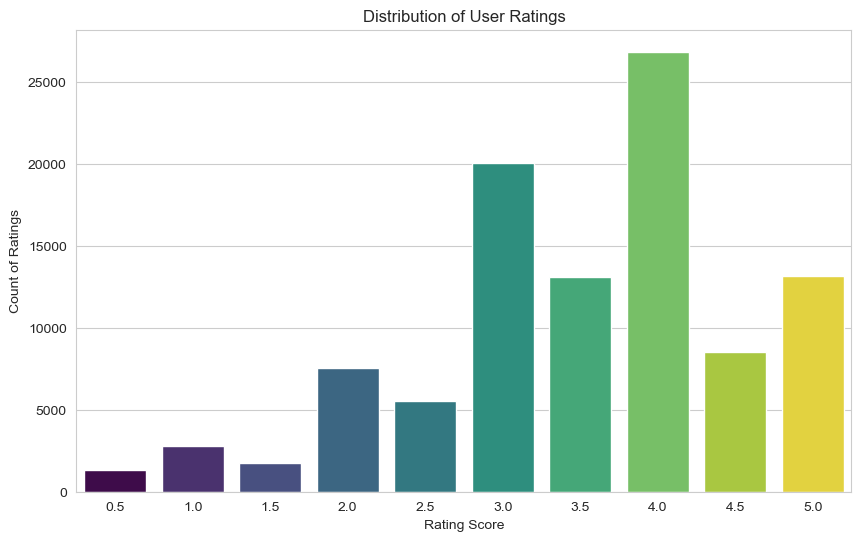

In [7]:
# 4. Distribution of Ratings
# --------------------------
# Are users generally positive (giving 4s and 5s) or negative?
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, hue='rating', palette='viridis', legend=False)
plt.title('Distribution of User Ratings')
plt.xlabel('Rating Score')
plt.ylabel('Count of Ratings')
plt.show()


### 5. Ratings per Movie (Long Tail)
This plot illustrates the "Long Tail" phenomenon common in recommender systems. We expect to see a small number of popular movies receiving the majority of ratings, while most movies receive very few.


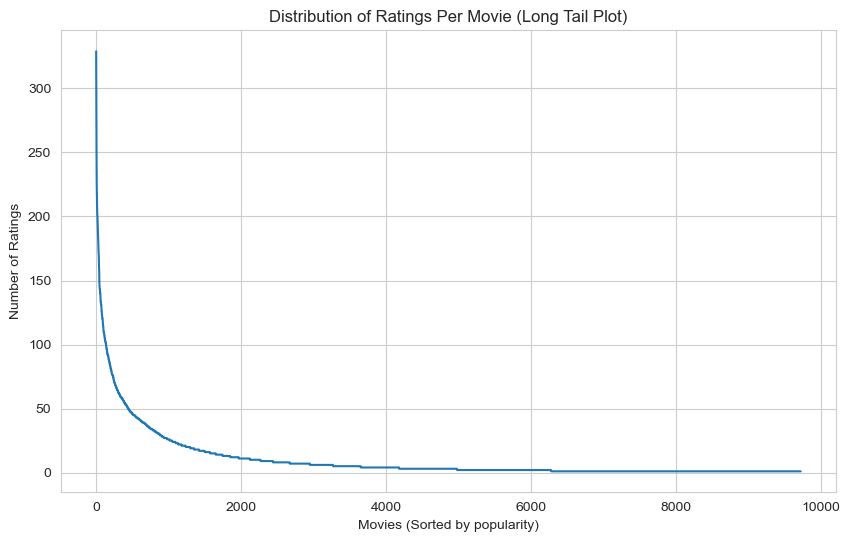


Top 5 Most Rated Movies (by ID):
movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64


In [8]:
# 5. Ratings per Movie (Long Tail)
# --------------------------------
# Some movies have thousands of ratings, most have very few.
ratings_per_movie = df.groupby('movieId')['rating'].count().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(ratings_per_movie.values)
plt.title('Distribution of Ratings Per Movie (Long Tail Plot)')
plt.xlabel('Movies (Sorted by popularity)')
plt.ylabel('Number of Ratings')
plt.show()

print("\nTop 5 Most Rated Movies (by ID):")
print(ratings_per_movie.head())


### 6. Ratings per User
We analyze user activity levels to see the distribution of how many ratings individual users provide. This helps identify "power users" versus casual users.


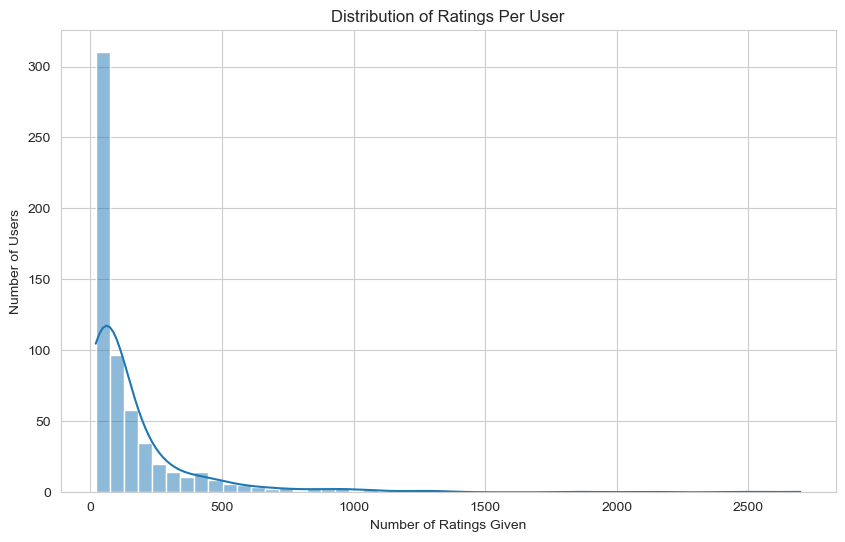


Average ratings per user: 165.30


In [9]:
# 6. Ratings per User
# -------------------
# How active are the users?
ratings_per_user = df.groupby('userId')['rating'].count()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.title('Distribution of Ratings Per User')
plt.xlabel('Number of Ratings Given')
plt.ylabel('Number of Users')
plt.show()

print(f"\nAverage ratings per user: {ratings_per_user.mean():.2f}")

### 7. Temporal Analysis
We analyze how the data changes over time to understand platform growth and user behavior.

**Ratings per Year:** This plot shows the total volume of ratings collected each year, highlighting trends in user activity and data availability over time.


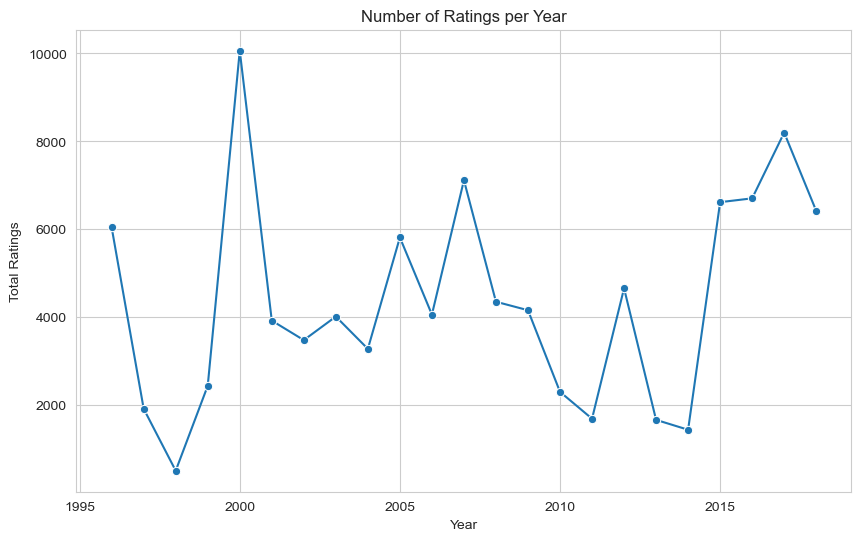

In [10]:
# %%
# 7. Ratings Over Time
# --------------------
# Convert the 'timestamp' column (seconds since 1970) to a datetime object
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract the year from the date
df['year'] = df['date'].dt.year

# Group by year to see the trend
ratings_per_year = df.groupby('year')['rating'].count()

plt.figure(figsize=(10, 6))
sns.lineplot(x=ratings_per_year.index, y=ratings_per_year.values, marker='o')
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Total Ratings')
plt.grid(True)
plt.show()

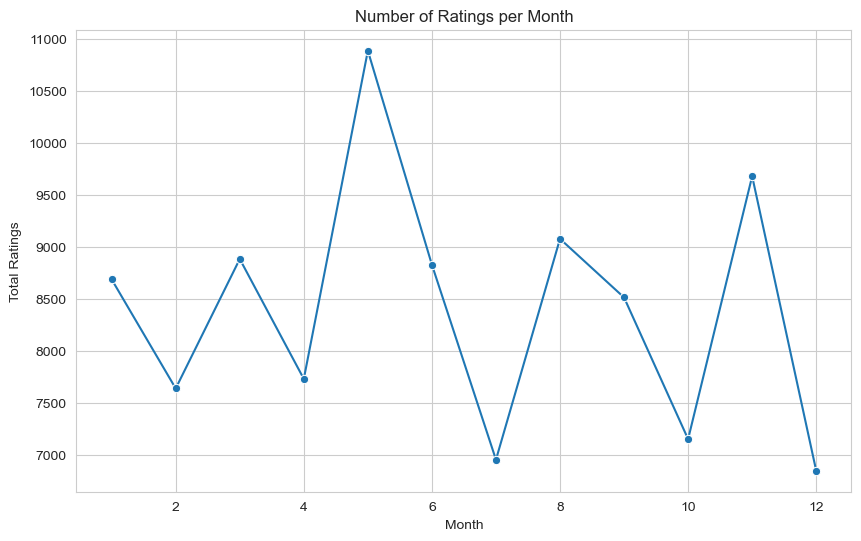

In [11]:
# %%
# 8. Ratings Over Time
# --------------------
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract the month from the date
df['month'] = df['date'].dt.month

# Group by month to see the trend
ratings_per_month = df.groupby('month')['rating'].count()

plt.figure(figsize=(10, 6))
sns.lineplot(x=ratings_per_month.index, y=ratings_per_month.values, marker='o')
plt.title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Total Ratings')
plt.grid(True)
plt.show()

 **Unique Users per Year:** This graph displays the number of unique users active each year, allowing us to see the growth of the user base distinct from the total number of ratings.


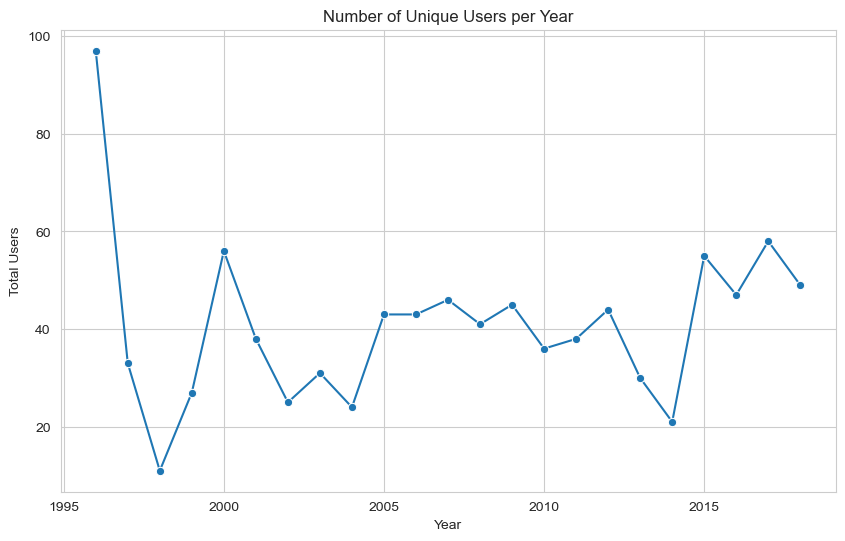

In [12]:
# Group by year to see the trend
users_per_year = df.groupby('year')['userId'].nunique()

plt.figure(figsize=(10, 6))
sns.lineplot(x=users_per_year.index, y=users_per_year.values, marker='o')
plt.title('Number of Unique Users per Year')
plt.xlabel('Year')
plt.ylabel('Total Users')
plt.grid(True)
plt.show()

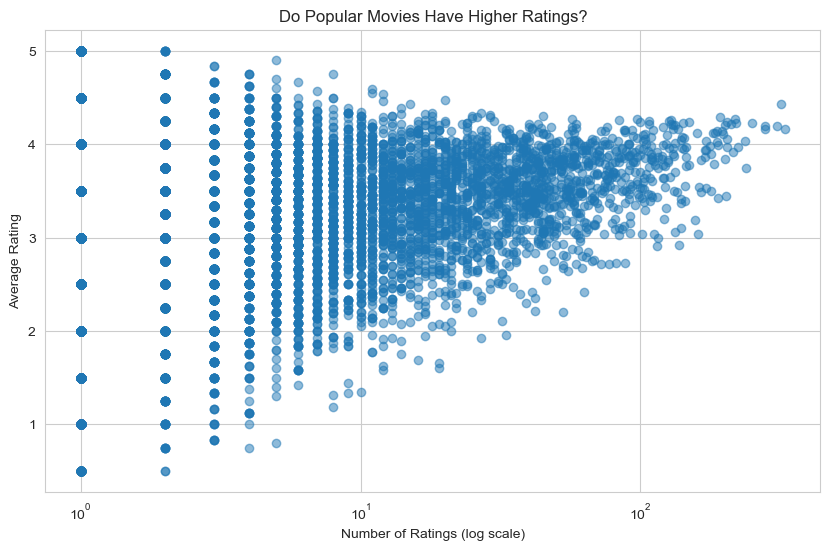

Correlation between number of ratings and average rating: 0.127


In [13]:
# %%
# 10.Do Popular Movies Have Higher Ratings?
# --------------------
# Compute number of ratings and mean rating per item
movie_stats = df.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()
movie_stats.rename(columns={'count':'num_ratings', 'mean':'mean_rating'}, inplace=True)

#print(movie_stats.head())
plt.figure(figsize=(10,6))
plt.scatter(movie_stats['num_ratings'], movie_stats['mean_rating'], alpha=0.5)
plt.xscale('log')  # Log scale for number of ratings
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Average Rating")
plt.title("Do Popular Movies Have Higher Ratings?")
plt.show()
corr = movie_stats['num_ratings'].corr(movie_stats['mean_rating'])
print(f"Correlation between number of ratings and average rating: {corr:.3f}")


# Collaborative Filtering – Memory Based Implementation

In [12]:
# Surprise requires the data to be in a specific format: [user, item, rating]
data_df = df[['userId', 'movieId', 'rating']]

# Define the rating scale (MovieLens ratings range from 0.5 to 5.0)
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataframe into the Surprise Dataset format
surprise_data = Dataset.load_from_df(data_df, reader)

In [60]:
# Configure the Algorithm
# - name: 'cosine' specifies the similarity metric.
# - user_based: False switches the mode to Item-Based (Item-to-Item).
#               (If True, it would be User-to-User).
sim_options_item = {
    'name': 'cosine',
    'user_based': False 
}

sim_options_user = {
    'name': 'cosine',
    'user_based': True 
}

In [61]:
# Experiment with different k values
k_values = [3, 5, 10]
results_list = []

print(f"Running Item-Based KNN with Cosine similarity for k={k_values}...")

for k in k_values:
    print(f"\n--- Training KNN with k={k} ---")
    # Initialize KNN with the specific k
    knn_item = KNNBasic(k=k, sim_options=sim_options_item, verbose=False)
    
    # Run 5-fold cross-validation
    cv_results = cross_validate(knn_item, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)
    
    # Calculate average metrics
    avg_mse = cv_results['test_mse'].mean()
    avg_mae = cv_results['test_mae'].mean()
    
    # Store results
    results_list.append({'Memory Based':'Item Based', 'k': k, 'MSE': avg_mse, 'MAE': avg_mae})
    print(f"k={k}: MSE={avg_mse:.4f}, MAE={avg_mae:.4f}")


Running Item-Based KNN with Cosine similarity for k=[3, 5, 10]...

--- Training KNN with k=3 ---
k=3: MSE=1.2589, MAE=0.8684

--- Training KNN with k=5 ---
k=5: MSE=1.1413, MAE=0.8315

--- Training KNN with k=10 ---
k=10: MSE=1.0426, MAE=0.7960


In [62]:
print(f"Running User-Based KNN with Cosine similarity for k={k_values}...")

for k in k_values:
    print(f"\n--- Training KNN with k={k} ---")
    # Initialize KNN with the specific k
    knn_user = KNNBasic(k=k, sim_options=sim_options_user, verbose=False)
    
    # Run 5-fold cross-validation
    cv_results = cross_validate(knn_user, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)
    
    # Calculate average metrics
    avg_mse = cv_results['test_mse'].mean()
    avg_mae = cv_results['test_mae'].mean()
    
    # Store results
    results_list.append({'Memory Based':'User Based', 'k': k, 'MSE': avg_mse, 'MAE': avg_mae})
    print(f"k={k}: MSE={avg_mse:.4f}, MAE={avg_mae:.4f}")


Running User-Based KNN with Cosine similarity for k=[3, 5, 10]...

--- Training KNN with k=3 ---
k=3: MSE=1.1247, MAE=0.8165

--- Training KNN with k=5 ---
k=5: MSE=1.0392, MAE=0.7823

--- Training KNN with k=10 ---
k=10: MSE=0.9758, MAE=0.7574


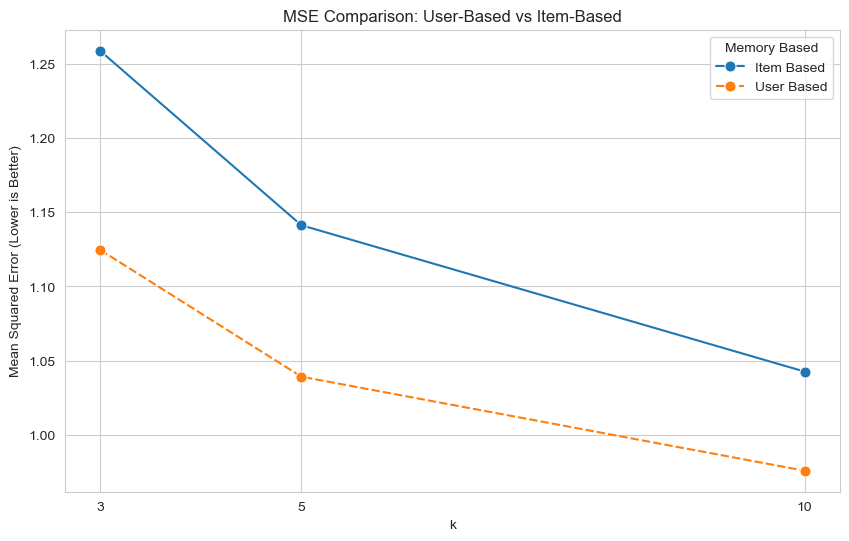

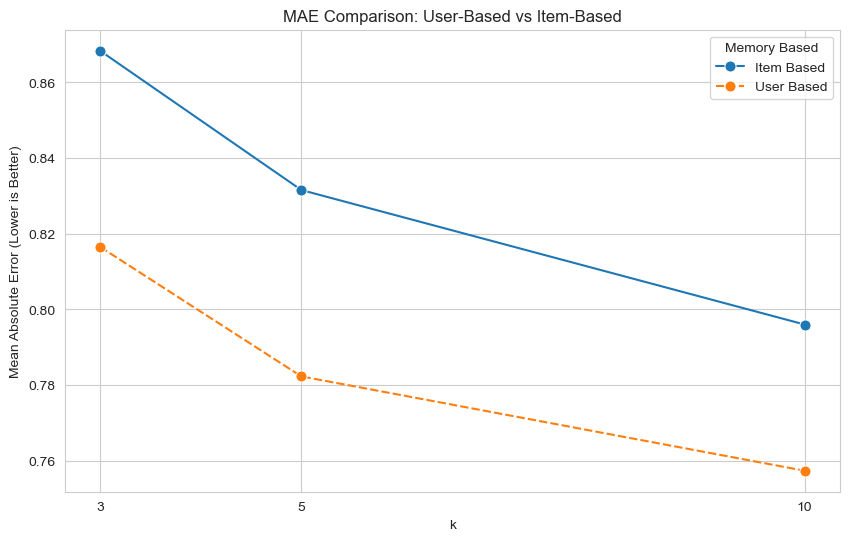


Final Results Summary:
  Memory Based   k       MSE       MAE
0   Item Based   3  1.258924  0.868355
1   Item Based   5  1.141291  0.831549
2   Item Based  10  1.042626  0.796017
3   User Based   3  1.124722  0.816539
4   User Based   5  1.039205  0.782307
5   User Based  10  0.975791  0.757382


In [63]:
# Create DataFrame for Plotting
results_df = pd.DataFrame(results_list)

# Plot MSE vs K
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='k', y='MSE', hue='Memory Based', marker='o', style='Memory Based', markersize=8)
plt.title('MSE Comparison: User-Based vs Item-Based')
plt.xticks(k_values)
plt.ylabel('Mean Squared Error (Lower is Better)')
plt.grid(True)
plt.show()

# 6. Plot MAE vs K
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='k', y='MAE', hue='Memory Based', marker='o', style='Memory Based', markersize=8)
plt.title('MAE Comparison: User-Based vs Item-Based')
plt.xticks(k_values)
plt.ylabel('Mean Absolute Error (Lower is Better)')
plt.grid(True)
plt.show()

# 7. Print Final Summary Table
print("\nFinal Results Summary:")
print(results_df)

### Explaning the results

We were expecting the item based approach to perform better than the user based approach, as we saw in the lectures, yet here we can see that both evaluations (MSE and MAE) have better results with the user based model. 

This result is likely due to the specific characteristics of the MovieLens Small dataset:

The dataset contains only 610 users compared to roughly 9,724 movies. This means the 'User Space' is significantly smaller and denser than the 'Item Space.' It is statistically easier for the algorithm to find reliable neighbors among a small group of users than to find similar items within a vast, sparse catalog of movies. Also, from the "Distribution of Ratings per Movies" graph in the previous section, we saw that low number of movies were rated, obviously the popular ones, this will positivly affect the model of user based, because most users rated the same popular movies, this makes it easier to ensure high overlap for the Cosine Similarity calculation.
For the same reason of rating popular movies, the Item-Based model likely suffered from the 'Long Tail' problem, where thousands of movies have very few ratings, making their similarity scores unreliable.

We also observed that increasing the neighborhood size (K) from 3 to 10  reduced error rates. This suggests that relying on a very small number of neighbors (K=3) makes the model sensitive to outliers, whereas (K=10) provides a more robust average.

In [20]:
# Define the models to evaluate
models = {
    'SVD': SVD(random_state=42),
    'SVD++': SVDpp(random_state=42),
    'NMF': NMF(random_state=42)
}

model_results = []

print("Running Model-Based Cross-Validation with default models as implemented by surprise...")

# Iterate through models and run 5-fold CV
for name, algo in models.items():
    print(f"\n--- Evaluating {name} ---")
    cv_res = cross_validate(algo, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)
    
    avg_mse = cv_res['test_mse'].mean()
    avg_mae = cv_res['test_mae'].mean()
    
    model_results.append({
        'Model': name,
        'MSE': avg_mse,
        'MAE': avg_mae
    })
    print(f"{name} -> MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}")

# Create a DataFrame for the final table
final_model_df = pd.DataFrame(model_results)

# 4. Highlight the best metrics programmatically
best_mse_val = final_model_df['MSE'].min()
best_mae_val = final_model_df['MAE'].min()

# 5. Display the Final Table
print("\n" + "="*40)
print("FINAL MODEL COMPARISON RESULTS")
print("="*40)
print(final_model_df.to_string(index=False))
print("-" * 40)
print(f"Best MSE: {best_mse_val:.4f} (Model: {final_model_df.loc[final_model_df['MSE'] == best_mse_val, 'Model'].values[0]})")
print(f"Best MAE: {best_mae_val:.4f} (Model: {final_model_df.loc[final_model_df['MAE'] == best_mae_val, 'Model'].values[0]})")
print("="*40)

Running Model-Based Cross-Validation with default models as implemented by surprise...

--- Evaluating SVD ---
SVD -> MSE: 0.7627, MAE: 0.6714

--- Evaluating SVD++ ---
SVD++ -> MSE: 0.7393, MAE: 0.6590

--- Evaluating NMF ---
NMF -> MSE: 0.8496, MAE: 0.7060

FINAL MODEL COMPARISON RESULTS
Model      MSE      MAE
  SVD 0.762678 0.671434
SVD++ 0.739326 0.659041
  NMF 0.849614 0.706004
----------------------------------------
Best MSE: 0.7393 (Model: SVD++)
Best MAE: 0.6590 (Model: SVD++)


In [21]:
# Define the models to evaluate _ this time with n_factors 
models_nf = {
    'SVD': SVD(n_factors=5, random_state=42),
    'SVD++': SVDpp(n_factors=5, random_state=42),
    'NMF': NMF(n_factors=5, biased=True, random_state=42)
}

model_results_nf = []

print("Running Model-Based Cross-Validation, the dimention of the latent space was choosen to be 5 for all three algorithms...")

# Iterate through models and run 5-fold CV
for name, algo in models_nf.items():
    print(f"\n--- Evaluating {name} ---")
    cv_res = cross_validate(algo, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)
    
    avg_mse = cv_res['test_mse'].mean()
    avg_mae = cv_res['test_mae'].mean()
    
    model_results_nf.append({
        'Model': name,
        'MSE': avg_mse,
        'MAE': avg_mae
    })
    print(f"{name} -> MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}")

# Create a DataFrame for the final table
final_model_df_with_nf = pd.DataFrame(model_results_nf)

# 4. Highlight the best metrics programmatically
best_mse_val_nf = final_model_df_with_nf['MSE'].min()
best_mae_val_nf = final_model_df_with_nf['MAE'].min()

# 5. Display the Final Table
print("\n" + "="*40)
print("FINAL MODEL COMPARISON RESULTS")
print("="*40)
print(final_model_df_with_nf.to_string(index=False))
print("-" * 40)
print(f"Best MSE: {best_mse_val_nf:.4f} (Model: {final_model_df_with_nf.loc[final_model_df_with_nf['MSE'] == best_mse_val_nf, 'Model'].values[0]})")
print(f"Best MAE: {best_mae_val_nf:.4f} (Model: {final_model_df_with_nf.loc[final_model_df_with_nf['MAE'] == best_mae_val_nf, 'Model'].values[0]})")
print("="*40)

Running Model-Based Cross-Validation, the dimention of the latent space was choosen to be 5 for all three algorithms...

--- Evaluating SVD ---
SVD -> MSE: 0.7561, MAE: 0.6685

--- Evaluating SVD++ ---
SVD++ -> MSE: 0.7413, MAE: 0.6598

--- Evaluating NMF ---
NMF -> MSE: 0.7625, MAE: 0.6690

FINAL MODEL COMPARISON RESULTS
Model      MSE      MAE
  SVD 0.756147 0.668484
SVD++ 0.741282 0.659827
  NMF 0.762510 0.668987
----------------------------------------
Best MSE: 0.7413 (Model: SVD++)
Best MAE: 0.6598 (Model: SVD++)


### Summary of Model-Based Approaches

In this section, we evaluated three Matrix Factorization algorithms: **SVD**, **SVD++**, and **NMF**. We conducted the experiment in two phases: first using the library's default hyperparameters, and second by standardizing the latent dimension ($k$) to ensure a fair comparison.

#### 1. Hyperparameter Tuning
* **Default Dimensions:** The default `n_factors` (k) in the Surprise library vary significantly between models (SVD: $k=100$, SVD++: $k=20$, NMF: $k=15$).
* **Standardized Dimensions:** To compare the algorithms fairly, we tested setting `n_factors` to both 5 and 50 for all models. We observed that **$k=5$ yielded better results** (likely due to the small size of the dataset avoiding overfitting), so we used $k=5$ for the final comparison.
* **Biased NMF:** In the second phase, we explicitly set `biased=True` for the NMF model (default is False). This allowed NMF to learn user and item biases, ensuring that the primary structural difference remaining between it and SVD was the non-negative constraint.
* **Regularization:** We attempted to standardize the regularization for NMF to `0.02` (to match SVD/SVD++), but this degraded performance. We decided to keep NMF at its default regularization of `0.06`.

#### 2. Results & Interpretation
The final results show that **SVD++** performed best, followed by **SVD**, with **NMF** performing the worst.

* **1st Place: SVD++**
    * **Reason:** It achieves the lowest error because it incorporates **implicit feedback**. It accounts not just for the explicit rating value, but also for the fact that a user *chose* to rate an item at all. This additional layer of information is crucial for sparse datasets like ours.

* **2nd Place: SVD**
    * **Reason:** SVD performs well because it uses **standard Matrix Factorization**, allowing latent factors to be negative. This flexibility allows the model to capture complex user preferences (e.g., a "negative" affinity for a specific genre). Additionally, SVD includes **bias terms** (user and item biases), which helps separate user leniency from actual preference.

* **3rd Place: NMF**
    * **Reason:** NMF had the highest error. This is expected for two reasons:
        1.  **Non-Negative Constraint:** By forcing all factors to be positive ($\ge 0$), the model loses the ability to represent "dislike" or negative correlations effectively.
        2.  **Lack of Bias:** The default NMF implementation is unbiased, meaning it does not account for the fact that some users inherently rate higher or some movies are inherently more popular.